In [330]:
# https://pypi.org/project/nfl-data-py/0.1.2/
    
!pip install nfl_data_py
!pip install xgboost
!pip install lightgbm
!pip install bayesian-optimization
!pip install shap --user

The system cannot find the path specified.


The system cannot find the path specified.


The system cannot find the path specified.


The system cannot find the path specified.


  Using cached slicer-0.0.7-py3-none-any.whl (14 kB)
  Using cached tqdm-4.64.1-py2.py3-none-any.whl (78 kB)


The system cannot find the path specified.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1376]:
import nfl_data_py as nfl

import os
import pickle
import numpy as np
import pandas as pd
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.feature_selection import RFE
from sklearn.utils import shuffle

In [1377]:
def _corr(df_, threshold=0.95, impute=0, keep=[]):
    """
    A function to find the ocrrelated variables
    inputs :
            df : dataframe
            threshold : correlation threshold value as a cut-off
            impute : string for dataframes with Null values : can be "mean" and "median"
                     If nothing passes, it will be None. Pandas by default drops the null values
    output : pruned dataframe
    """
    # check for imputation
    if impute == "median":
        df = df_.copy()
        df.fillna(df.median(), inplace=True)
    elif impute == "mean":
        df = df_.copy()
        df.fillna(df.mean(), inplace=True)
    else:
        df = df_.copy()

    # pair-wised correlation:
    # methods can be pearosn, kendall, and spearman
    # min_periods sets the minimum number of observation for each feature
    corr = df.corr(method="pearson", min_periods=1)

    # mean of absoulte value of the of each column of the correlation matrix
    mean_corr_col = abs(corr).mean(axis=1)

    # empty list for adding correlated columns
    correlated_cols = []
    for i in range(len(corr)):
        for j in range(len(corr)):
            # skip this round if one of them is already removed
            if (
                i != j
                and corr.iloc[i, j] > threshold
                and corr.columns[i] not in correlated_cols
                and corr.columns[j] not in correlated_cols
            ):

                # prefer group concept because they are in clinical profile and literatures
                # prefer last because it is most eaily to understood by clinicans, last also would be better than first in terms of model auc
                if "group" in corr.columns[j].lower() or corr.columns[j] in keep:
                    correlated_cols.append(corr.columns[i])
                    print("1. Keep: ", corr.columns[j], " Remove: ", corr.columns[i])
                elif "group" in corr.columns[i].lower() or corr.columns[i] in keep:
                    correlated_cols.append(corr.columns[j])
                    print("2. Keep: ", corr.columns[i], " Remove: ", corr.columns[j])
                elif mean_corr_col[i] >= mean_corr_col[j]:
                    correlated_cols.append(corr.columns[i])
                    print(
                        "3. Keep: ",
                        corr.columns[j],
                        mean_corr_col[j],
                        " Remove: ",
                        corr.columns[i],
                        mean_corr_col[i],
                    )

    # dropping correlated features
    drops = list(set(correlated_cols))
    print("Dropping below: ", drops)
    df_pruned = df.drop(drops, axis=1)

    return df_pruned

# add random shuffled columns for feature selection threshold later
def permute(df):
    """
    a funtion to permute the rows of features and add them
    to the dataframe as noisy features to explore stability
    """
    ids = [col for col in df.columns.tolist() if col not in ['player_id','first_name','last_name','team','position','season','week','fantasy_points_ppr']]
    noisy_df = df.loc[:, ids].copy()
    noisy_df.rename(
        columns={col: "random_" + col for col in noisy_df.columns}, inplace=True
    )
    noisy_df = noisy_df.reindex(shuffle(noisy_df.index)).reset_index(drop=True)
    merged_df = pd.concat([df.reset_index(drop=True), noisy_df], axis=1)
    #     merged_df = pd.concat([df.reset_index(drop = True), noisy_df[noisy_df.columns[::3]]] , axis = 1)
    return merged_df

In [1378]:
years = [2016, 2017, 2018, 2019, 2020, 2021]

In [1379]:
nfl.import_pbp_data(years, downcast=True, cache=False, alt_path=None)

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
Downcasting floats.


,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,possession_team,offense_formation,offense_personnel,defenders_in_box,defense_personnel,number_of_pass_rushers,offense_players,n_offense,defense_players,n_defense
0,1.0,2016_01_BUF_BAL,2016091101,BAL,BUF,REG,1,None,None,None,...,,None,None,NaN,None,NaN,,0.0,,0.0
1,36.0,2016_01_BUF_BAL,2016091101,BAL,BUF,REG,1,BAL,home,BUF,...,BUF,None,None,NaN,None,NaN,00-0030041;00-0030073;00-0029799;00-0030433;00...,10.0,00-0029892;00-0029895;00-0028497;00-0027539;00...,11.0
2,58.0,2016_01_BUF_BAL,2016091101,BAL,BUF,REG,1,BAL,home,BUF,...,BAL,I_FORM,"2 RB, 1 TE, 2 WR",8.0,"4 DL, 3 LB, 4 DB",NaN,00-0029892;00-0027714;00-0032965;00-0029893;00...,11.0,00-0029542;00-0031171;00-0029566;00-0030073;00...,11.0
3,85.0,2016_01_BUF_BAL,2016091101,BAL,BUF,REG,1,BAL,home,BUF,...,BAL,SHOTGUN,"2 RB, 1 TE, 2 WR",6.0,"4 DL, 3 LB, 4 DB",3.0,00-0029892;00-0027714;00-0032965;00-0029893;00...,11.0,00-0031171;00-0029542;00-0029566;00-0030073;00...,11.0
4,109.0,2016_01_BUF_BAL,2016091101,BAL,BUF,REG,1,BAL,home,BUF,...,BAL,SHOTGUN,"2 RB, 1 TE, 2 WR",7.0,"4 DL, 3 LB, 4 DB",NaN,00-0029892;00-0027714;00-0032965;00-0029893;00...,11.0,00-0029542;00-0031171;00-0029566;00-0030073;00...,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291545,3930.0,2021_22_LA_CIN,2022021300,CIN,LA,POST,22,CIN,home,LA,...,CIN,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",NaN,00-0032134;00-0032043;00-0036310;00-0033009;00...,11.0,00-0033072;00-0035663;00-0025424;00-0035667;00...,11.0
291546,3951.0,2021_22_LA_CIN,2022021300,CIN,LA,POST,22,None,None,None,...,,None,None,NaN,None,NaN,,0.0,,0.0
291547,3968.0,2021_22_LA_CIN,2022021300,CIN,LA,POST,22,CIN,home,LA,...,CIN,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",3.0,00-0032134;00-0032043;00-0036310;00-0033009;00...,11.0,00-0033072;00-0035663;00-0025424;00-0035667;00...,11.0
291548,3990.0,2021_22_LA_CIN,2022021300,CIN,LA,POST,22,LA,away,CIN,...,LA,None,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",NaN,00-0036424;00-0032242;00-0034804;00-0034449;00...,11.0,00-0034834;00-0032379;00-0033548;00-0034675;00...,11.0


In [1380]:
nfl.see_pbp_cols()

Index(['play_id', 'game_id', 'old_game_id', 'home_team', 'away_team',
       'season_type', 'week', 'posteam', 'posteam_type', 'defteam',
       ...
       'out_of_bounds', 'home_opening_kickoff', 'qb_epa', 'xyac_epa',
       'xyac_mean_yardage', 'xyac_median_yardage', 'xyac_success', 'xyac_fd',
       'xpass', 'pass_oe'],
      dtype='object', length=372)

In [1381]:
weekly_df = nfl.import_weekly_data(years)
weekly_df.head()
print(weekly_df.shape)

Downcasting floats.
(32280, 48)


In [1382]:
nfl.see_weekly_cols()

Index(['player_id', 'player_name', 'recent_team', 'season', 'week',
       'season_type', 'completions', 'attempts', 'passing_yards',
       'passing_tds', 'interceptions', 'sacks', 'sack_yards', 'sack_fumbles',
       'sack_fumbles_lost', 'passing_air_yards', 'passing_yards_after_catch',
       'passing_first_downs', 'passing_epa', 'passing_2pt_conversions',
       'dakota', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles',
       'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa',
       'rushing_2pt_conversions', 'receptions', 'targets', 'receiving_yards',
       'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost',
       'receiving_air_yards', 'receiving_yards_after_catch',
       'receiving_first_downs', 'receiving_epa', 'receiving_2pt_conversions',
       'special_teams_tds', 'fantasy_points', 'fantasy_points_ppr'],
      dtype='object')

In [1383]:
season_df = nfl.import_seasonal_data(years)
season_df.head()

,player_id,season,season_type,completions,attempts,passing_yards,passing_tds,interceptions,sacks,sack_yards,...,yac_sh,wopr_y,ry_sh,rtd_sh,rfd_sh,rtdfd_sh,dom,w8dom,yptmpa,ppr_sh
0,00-0019596,2016,REG,291,432,3554.0,28,2.0,15.0,87.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.201465
1,00-0019596,2017,REG,385,581,4577.0,32,8.0,35.0,201.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.181459
2,00-0019596,2018,REG,375,570,4355.0,29,11.0,21.0,147.0,...,0.002757,0.002613,0.001362,0.0,0.0,0.0,0.000681,0.00109,0.010453,0.178445
3,00-0019596,2019,REG,373,613,4057.0,24,8.0,27.0,185.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.179165
4,00-0019596,2020,REG,401,610,4633.0,40,12.0,21.0,143.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.197091


In [1384]:
print(list(season_df.columns))

['player_id', 'season', 'season_type', 'completions', 'attempts', 'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_yards', 'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards', 'passing_yards_after_catch', 'passing_first_downs', 'passing_epa', 'passing_2pt_conversions', 'dakota', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions', 'receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards', 'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa', 'receiving_2pt_conversions', 'special_teams_tds', 'fantasy_points', 'fantasy_points_ppr', 'pacr', 'racr', 'target_share', 'air_yards_share', 'wopr_x', 'games', 'tgt_sh', 'ay_sh', 'yac_sh', 'wopr_y', 'ry_sh', 'rtd_sh', 'rfd_sh', 'rtdfd_sh', 'dom', 'w8dom', 'yptmpa', 'ppr_sh']


In [1385]:
roster_df = nfl.import_rosters(years)
roster_df['first_name'] = roster_df['first_name'].str.lower()
roster_df['last_name'] = roster_df['last_name'].str.lower()
roster_df.head()

,season,team,position,depth_chart_position,jersey_number,status,player_name,first_name,last_name,birth_date,...,game_type,status_description_abbr,football_name,esb_id,gsis_it_id,smart_id,entry_year,rookie_year,draft_club,draft_number
0,2016,ARI,DB,DB,43.0,None,Mike Jenkins,mike,jenkins,1985-03-22,...,REG,None,Mike,JEN421854,None,32004a45-4e42-1854-a332-1f8b24b65db4,NaN,NaN,None,NaN
1,2016,ARI,DB,SS,27.0,None,Tyvon Branch,tyvon,branch,1986-12-11,...,REG,None,Tyvon,BRA530779,None,32004252-4153-0779-8615-69f59ec1aef7,2008.0,2008.0,OAK,100.0
2,2016,ARI,DB,CB,21.0,None,Patrick Peterson,patrick,peterson,1990-07-11,...,REG,None,Patrick,PET415511,None,32005045-5441-5511-6ae6-059d8eb99a8d,NaN,NaN,None,NaN
3,2016,ARI,DB,CB,28.0,None,Justin Bethel,justin,bethel,1990-06-17,...,REG,None,Justin,BET201235,None,32004245-5420-1235-8b83-7aa6aa147af8,NaN,NaN,None,NaN
4,2016,ARI,DB,FS,36.0,None,D.J. Swearinger,d.j.,swearinger,1991-09-01,...,REG,None,D.J.,SWE023150,None,32005357-4502-3150-3be8-2dd57069939a,NaN,NaN,None,NaN


In [1386]:
roster_df.loc[(roster_df['first_name'] == 'joshua') & (roster_df['last_name'] == 'allen')]

,season,team,position,depth_chart_position,jersey_number,status,player_name,first_name,last_name,birth_date,...,game_type,status_description_abbr,football_name,esb_id,gsis_it_id,smart_id,entry_year,rookie_year,draft_club,draft_number
407,2018,BUF,QB,QB,17.0,Active,Josh Allen,joshua,allen,1996-05-21,...,REG,A01,Josh,ALL529264,46076,3200414c-4c52-9264-bedc-c4ddaf201fe7,2018.0,2018.0,BUF,7.0
391,2019,BUF,QB,QB,17.0,Active,Josh Allen,joshua,allen,1996-05-21,...,WC,A01,Josh,ALL529264,46076,3200414c-4c52-9264-bedc-c4ddaf201fe7,2018.0,2018.0,BUF,7.0
1512,2019,JAX,DL,DE,41.0,Active,Josh Allen,joshua,allen,1997-07-13,...,REG,A01,Josh,ALL528759,47790,3200414c-4c52-8759-5d19-904fa0fc8823,2019.0,2019.0,JAX,7.0
314,2020,BUF,QB,QB,17.0,Active,Josh Allen,joshua,allen,1996-05-21,...,CON,A01,Josh,ALL529264,46076,3200414c-4c52-9264-bedc-c4ddaf201fe7,2018.0,2018.0,BUF,7.0
1311,2020,JAX,DL,DE,41.0,R/Injured,Josh Allen,joshua,allen,1997-07-13,...,REG,R01,Josh,ALL528759,47790,3200414c-4c52-8759-5d19-904fa0fc8823,2019.0,2019.0,JAX,7.0
340,2021,BUF,QB,QB,17.0,Active,Josh Allen,joshua,allen,1996-05-21,...,DIV,A01,Josh,ALL529264,46076,3200414c-4c52-9264-bedc-c4ddaf201fe7,2018.0,2018.0,BUF,7.0
1348,2021,JAX,LB,OLB,41.0,Active,Josh Allen,joshua,allen,1997-07-13,...,REG,A01,Josh,ALL528759,47790,3200414c-4c52-8759-5d19-904fa0fc8823,2019.0,2019.0,JAX,7.0


In [1387]:
print(list(roster_df.columns))

['season', 'team', 'position', 'depth_chart_position', 'jersey_number', 'status', 'player_name', 'first_name', 'last_name', 'birth_date', 'height', 'weight', 'college', 'player_id', 'espn_id', 'sportradar_id', 'yahoo_id', 'rotowire_id', 'pff_id', 'pfr_id', 'fantasy_data_id', 'sleeper_id', 'years_exp', 'headshot_url', 'ngs_position', 'week', 'game_type', 'status_description_abbr', 'football_name', 'esb_id', 'gsis_it_id', 'smart_id', 'entry_year', 'rookie_year', 'draft_club', 'draft_number']


In [1388]:
roster_df[["position","player_id"]].groupby(["position"])["player_id"].count().reset_index(name="count")

,position,count
0,DB,3200
1,DL,2561
2,K,1
3,LB,2251
4,OL,2891
5,QB,722
6,RB,1403
7,SPEC,811
8,TE,1153
9,WR,2168


In [1389]:
roster_df.drop(['player_name','season','week'], axis=1, inplace=True)
weekly_roster_df = weekly_df.merge(roster_df, on='player_id', how='left')
weekly_roster_df = weekly_roster_df[(weekly_roster_df['status']=='Active')]
weekly_roster_df.shape

(110660, 80)

In [1390]:
weekly_roster_df[["position","player_id"]].groupby(["position"])["player_id"].count().reset_index(name="count")

,position,count
0,DB,473
1,DL,63
2,LB,103
3,OL,188
4,QB,15442
5,RB,28866
6,SPEC,457
7,TE,22005
8,WR,43063


In [1391]:
print(list(weekly_roster_df.columns))

['player_id', 'player_name', 'recent_team', 'season', 'week', 'season_type', 'completions', 'attempts', 'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_yards', 'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards', 'passing_yards_after_catch', 'passing_first_downs', 'passing_epa', 'passing_2pt_conversions', 'dakota', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions', 'receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards', 'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa', 'receiving_2pt_conversions', 'special_teams_tds', 'fantasy_points', 'fantasy_points_ppr', 'pacr', 'racr', 'target_share', 'air_yards_share', 'wopr', 'team', 'position', 'depth_chart_position', 'jersey_number', 'status', 'first_name', 'last_name', 'birth_date', 'height', 'weight', 'college', 'espn_id', 'spo

In [1392]:
##Sort By Players & Week (Make Sure Weeks Go From 1 to 17 for ETL)
weekly_roster_df.sort_values(['player_id', 'week'], ascending = [True, True], inplace = True)
weekly_roster_df.head()

,player_id,player_name,recent_team,season,week,season_type,completions,attempts,passing_yards,passing_tds,...,game_type,status_description_abbr,football_name,esb_id,gsis_it_id,smart_id,entry_year,rookie_year,draft_club,draft_number
22929,00-0019596,T.Brady,NE,2017,1,REG,16,36,267.0,0,...,SB,A01,Tom,BRA371156,25511,32004252-4137-1156-7ed0-8b9e44948f13,2000.0,2000.0,NE,199.0
22930,00-0019596,T.Brady,NE,2017,1,REG,16,36,267.0,0,...,SB,A01,Tom,BRA371156,25511,32004252-4137-1156-7ed0-8b9e44948f13,2000.0,2000.0,NE,199.0
22931,00-0019596,T.Brady,NE,2017,1,REG,16,36,267.0,0,...,WC,A01,Tom,BRA371156,25511,32004252-4137-1156-7ed0-8b9e44948f13,2000.0,2000.0,NE,199.0
22932,00-0019596,T.Brady,NE,2017,1,REG,16,36,267.0,0,...,SB,A01,Tom,BRA371156,25511,32004252-4137-1156-7ed0-8b9e44948f13,2000.0,2000.0,NE,199.0
22933,00-0019596,T.Brady,NE,2017,1,REG,16,36,267.0,0,...,DIV,A01,Tom,BRA371156,25511,32004252-4137-1156-7ed0-8b9e44948f13,2000.0,2000.0,NE,199.0


In [1393]:
weekly_rb_df = weekly_roster_df[(weekly_roster_df['position']=='RB')].copy().reset_index(drop=True)
len(weekly_rb_df)

28866

In [1394]:
weekly_qb_df = weekly_roster_df[(weekly_roster_df['position']=='QB')].copy().reset_index(drop=True)
len(weekly_qb_df)

15442

In [1395]:
 weekly_wr_df = weekly_roster_df[(weekly_roster_df['position']=='WR')].copy().reset_index(drop=True)
len(weekly_wr_df)

43063

In [1396]:
weekly_te_df = weekly_roster_df[(weekly_roster_df['position']=='TE')].copy().reset_index(drop=True)
len(weekly_te_df)

22005

### RB model

In [1397]:
weekly_rb_df.head()

,player_id,player_name,recent_team,season,week,season_type,completions,attempts,passing_yards,passing_tds,...,game_type,status_description_abbr,football_name,esb_id,gsis_it_id,smart_id,entry_year,rookie_year,draft_club,draft_number
0,00-0023500,F.Gore,IND,2016,1,REG,0,0,0.0,0,...,REG,A01,Frank,GOR411171,29892,3200474f-5241-1171-e932-18530d86ff0c,2005.0,2005.0,SF,65.0
1,00-0023500,F.Gore,IND,2016,1,REG,0,0,0.0,0,...,REG,A01,Frank,GOR411171,29892,3200474f-5241-1171-e932-18530d86ff0c,2005.0,2005.0,SF,65.0
2,00-0023500,F.Gore,IND,2016,1,REG,0,0,0.0,0,...,WC,A01,Frank,GOR411171,29892,3200474f-5241-1171-e932-18530d86ff0c,2005.0,2005.0,SF,65.0
3,00-0023500,F.Gore,IND,2017,1,REG,0,0,0.0,0,...,REG,A01,Frank,GOR411171,29892,3200474f-5241-1171-e932-18530d86ff0c,2005.0,2005.0,SF,65.0
4,00-0023500,F.Gore,IND,2017,1,REG,0,0,0.0,0,...,REG,A01,Frank,GOR411171,29892,3200474f-5241-1171-e932-18530d86ff0c,2005.0,2005.0,SF,65.0


In [1398]:
print(list(weekly_rb_df.columns))

['player_id', 'player_name', 'recent_team', 'season', 'week', 'season_type', 'completions', 'attempts', 'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_yards', 'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards', 'passing_yards_after_catch', 'passing_first_downs', 'passing_epa', 'passing_2pt_conversions', 'dakota', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions', 'receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards', 'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa', 'receiving_2pt_conversions', 'special_teams_tds', 'fantasy_points', 'fantasy_points_ppr', 'pacr', 'racr', 'target_share', 'air_yards_share', 'wopr', 'team', 'position', 'depth_chart_position', 'jersey_number', 'status', 'first_name', 'last_name', 'birth_date', 'height', 'weight', 'college', 'espn_id', 'spo

In [1399]:
##CREATE 3 Week MA
weekly_rb_df['rushing_3_week_sum'] = weekly_rb_df.groupby(['player_id'])['rushing_yards'].transform(lambda x: x.shift().rolling(3).sum())
weekly_rb_df['rushing_3_week_mean'] = weekly_rb_df.groupby(['player_id'])['rushing_yards'].transform(lambda x: x.shift().rolling(3, min_periods = 1).mean())

In [1400]:
# This will give us the running backs rank for rushing attempts over their last 3 weeks played.
weekly_rb_df['rushing_3_week_rank'] = weekly_rb_df[['rushing_3_week_mean','week']].groupby(['week']).rank(method='min')

In [1401]:
print(list(weekly_rb_df.columns))

['player_id', 'player_name', 'recent_team', 'season', 'week', 'season_type', 'completions', 'attempts', 'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_yards', 'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards', 'passing_yards_after_catch', 'passing_first_downs', 'passing_epa', 'passing_2pt_conversions', 'dakota', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions', 'receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards', 'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa', 'receiving_2pt_conversions', 'special_teams_tds', 'fantasy_points', 'fantasy_points_ppr', 'pacr', 'racr', 'target_share', 'air_yards_share', 'wopr', 'team', 'position', 'depth_chart_position', 'jersey_number', 'status', 'first_name', 'last_name', 'birth_date', 'height', 'weight', 'college', 'espn_id', 'spo

In [1402]:
# try to keep as much as possible
rb_act_stats = weekly_rb_df[['player_id','first_name','last_name','team','position','season','week','completions', 'attempts', 'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_yards', 'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards', 'passing_yards_after_catch', 'passing_first_downs', 'passing_epa', 'passing_2pt_conversions', 'dakota', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions', 'receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards', 'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa', 'receiving_2pt_conversions', 'special_teams_tds','fantasy_points_ppr', 'pacr', 'racr', 'target_share', 'air_yards_share', 'wopr', 'team', 'position',  'years_exp', 'rookie_year', 'draft_number', 'rushing_3_week_sum', 'rushing_3_week_mean', 'rushing_3_week_rank']].copy().reset_index(drop=True)

In [1403]:
rb_act_stats = rb_act_stats.fillna(0)

In [1404]:
rb_act_stats = rb_act_stats.loc[:,~rb_act_stats.columns.duplicated()]
rb_act_stats = rb_act_stats.replace([np.inf, -np.inf], np.nan)

In [1405]:
# remove correlated
rb_act_stats = _corr(rb_act_stats, threshold=0.85, impute=0, keep=['fantasy_points_ppr'])
print(rb_act_stats.shape)

3. Keep:  passing_yards_after_catch 0.10626068108833307  Remove:  passing_yards 0.12196193621135752
3. Keep:  sack_yards 0.059174906461048574  Remove:  sacks 0.0685637841592315
3. Keep:  sack_fumbles_lost 0.0636692757055032  Remove:  sack_fumbles 0.0636692757055032
3. Keep:  completions 0.1323272491654866  Remove:  passing_first_downs 0.13624864936911196
3. Keep:  carries 0.1798866854191232  Remove:  rushing_yards 0.18425993956348521
3. Keep:  targets 0.17386085568068527  Remove:  receptions 0.17676636452959943
3. Keep:  receiving_yards_after_catch 0.1761394201930026  Remove:  receiving_yards 0.1812191108074832
3. Keep:  target_share 0.10383465469249382  Remove:  wopr 0.10633459357012957
3. Keep:  rushing_3_week_rank 0.15619331968413203  Remove:  rushing_3_week_sum 0.16729805848126822
3. Keep:  rushing_3_week_rank 0.15619331968413203  Remove:  rushing_3_week_mean 0.16777625970668325
Dropping below:  ['sack_fumbles', 'rushing_3_week_mean', 'rushing_yards', 'sacks', 'wopr', 'rushing_3_we

In [1406]:
# permute the features for Wrapper feature selection

print(rb_act_stats.shape)
df = permute(rb_act_stats)
print(df.shape)

(28866, 44)
(28866, 80)


In [1407]:
# separate features to binary and continuous features
ids = [col for col in df.columns.tolist() if col not in ['player_id','first_name','last_name','team','position','season','week','fantasy_points_ppr']]
features = df.loc[:, ids]
bin_cols = [
    col for col in features if features[col].value_counts().index.isin([0, 1]).all()
]
cont_cols = [col for col in features.columns.tolist() if col not in bin_cols]
print(len(bin_cols))
print(len(cont_cols))

14
58


In [1408]:
## create tes-train split
X = df[bin_cols+cont_cols]
y = df["fantasy_points_ppr"]
## print df shape
print(X.shape)
print(y.shape)

(28866, 72)
(28866,)


In [1409]:
from xgboost import XGBRegressor

# create an xgboost regression model
model = XGBRegressor(params=xgb_params)

model.fit(X, y)
dset = pd.DataFrame({'attr':X.columns.tolist(),'importance':model.feature_importances_}).sort_values(by='importance', ascending=False).reset_index(drop=True)
attr = dset['attr'].tolist()
print(attr)

[01:15:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


['rushing_tds', 'rushing_first_downs', 'receiving_tds', 'receiving_yards_after_catch', 'receiving_first_downs', 'targets', 'carries', 'rushing_epa', 'special_teams_tds', 'rushing_2pt_conversions', 'receiving_epa', 'rushing_fumbles_lost', 'passing_tds', 'receiving_fumbles', 'receiving_2pt_conversions', 'receiving_air_yards', 'rushing_3_week_rank', 'receiving_fumbles_lost', 'passing_epa', 'target_share', 'air_yards_share', 'draft_number', 'rushing_fumbles', 'rookie_year', 'racr', 'attempts', 'passing_air_yards', 'random_racr', 'random_rushing_2pt_conversions', 'random_receiving_ep

In [1410]:
permutated = [name for name in attr if "random_" in name]
if len(permutated) == 0:
    top_n = len(attr)
else:
    print(permutated[0])
    top_n = attr.index(permutated[0])-1
top_n

random_racr


26

In [1411]:
## create tes-train split using top_n features
X = df[attr[:top_n]]
y = df["fantasy_points_ppr"]
## print df shape
print(X.shape)
print(y.shape)

(28866, 26)
(28866,)


In [1412]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import datetime
from sklearn.model_selection import GridSearchCV

xgb1 = XGBRegressor()
parameters = {
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [2, 3, 4],
              'min_child_weight': [4],
              'eta' : [0.1],
              'subsample': [0.7],
              'colsample_bytree': [0.8],
              'n_estimators': [200, 500, 1000]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 5,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X, y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[01:19:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
0.9721053872276565
{'colsample_bytree': 0.8, 'eta': 0.1, 'learning_rate': 0.07, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 1000, 'objective': 'reg:linear', 'subsample': 0.7}


In [1413]:
xgb_params = {}
for key, val in xgb_grid.best_params_.items():
        xgb_params[key] = val

In [1414]:
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold, KFold
from xgboost import XGBRegressor

# create an xgboost regression model
model = XGBRegressor(params=xgb_params)


# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

# kfold = KFold(n_splits=10, shuffle=True)
# kf_cv_scores = cross_val_score(model, X, y, cv=kfold )
# print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

Mean MAE: 0.611 (0.015)


In [1415]:
model.fit(X, y)
dset = pd.DataFrame({'attr':X.columns.tolist(),'importance':model.feature_importances_}).sort_values(by='importance', ascending=False).reset_index(drop=True)
attr = dset['attr'].tolist()
print(attr)

[01:20:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


['rushing_tds', 'receiving_tds', 'rushing_first_downs', 'receiving_yards_after_catch', 'receiving_first_downs', 'carries', 'targets', 'special_teams_tds', 'rushing_epa', 'rushing_2pt_conversions', 'passing_tds', 'receiving_epa', 'rushing_fumbles_lost', 'attempts', 'receiving_fumbles', 'receiving_2pt_conversions', 'receiving_air_yards', 'passing_epa', 'receiving_fumbles_lost', 'rushing_3_week_rank', 'rushing_fumbles', 'target_share', 'draft_number', 'racr', 'air_yards_share', 'rookie_year']


In [1416]:
# Model validation
# Use previous seasons data to predict 2021 season
cols = ['player_id','first_name','last_name','team','position','season','week','fantasy_points_ppr'] + attr


traindf = rb_act_stats[cols][(rb_act_stats['season']<=2020)].fillna(0).copy().drop_duplicates().reset_index(drop=True)
print(traindf.shape)
#Create Test Dataset
testdf  = rb_act_stats[cols][rb_act_stats['season']>=2021].fillna(0).copy().drop_duplicates().reset_index(drop=True)
print(testdf.shape)

(22256, 34)
(4503, 34)


In [1417]:
#Columns We Can't Include In Our Features Datasets
dcols = ['player_id','first_name','last_name','team','position','season','week','fantasy_points_ppr']
#X = Features, Y = Target
#train = training dataset, test = testing dataset
X_train, Y_train = traindf.drop(dcols, axis = 1), traindf['fantasy_points_ppr']
X_test, Y_test = testdf.drop(dcols, axis = 1), testdf['fantasy_points_ppr']
#Use For Analysis After Model & Predictions Created
pred_df = testdf.copy()

In [1418]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
mae = mean_absolute_error(Y_test, Y_pred)
print("MAE: %.2f" % mse)
mape = mean_absolute_percentage_error(Y_test, Y_pred)
print("MAPE: %.2f" % mape)

[01:20:24] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


MAE: 4.66
MAPE: 33688681185280.00


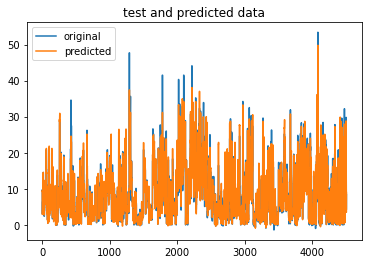

In [1419]:
import matplotlib.pyplot as plt 

x_ax = range(len(Y_test))
plt.plot(x_ax, Y_test, label="original")
plt.plot(x_ax, Y_pred, label="predicted")
plt.title("test and predicted data")
plt.legend()
plt.show()

In [1420]:
testdf['Predicted_fantasy'] = Y_pred
testdf['fantasy_points_ppr'] = Y_test

In [1421]:
player_df = pd.read_csv('2022_top_300_espn_ppr_projections.csv')
player_df.head()

,rank,first_name,last_name,team,position
0,1,jonathan,taylor,IND,RB
1,2,christian,mccaffrey,CAR,RB
2,3,cooper,kupp,LAR,WR
3,4,austin,ekeler,LAC,RB
4,5,justin,jefferson,MIN,WR


In [1422]:
rb_player_df = player_df.merge(testdf[['first_name','last_name','team','position','fantasy_points_ppr','Predicted_fantasy']], on=['first_name','last_name','team','position'])
rb_player_df.shape

(1320, 7)

In [1423]:
rb_player_df['median'] = rb_player_df.groupby(['first_name','last_name'])['Predicted_fantasy'].transform('median')
rb_player_df = rb_player_df.drop_duplicates(['first_name','last_name'])

rb_player_df = rb_player_df.loc[rb_player_df['median'].sort_values(ascending=False).index]
rb_player_df['position_rank'] = rb_player_df['median'].rank(ascending=False) 
rb_player_df.drop(['rank','fantasy_points_ppr','Predicted_fantasy'], axis=1, inplace=True)
rb_player_df.reset_index(drop=True, inplace=True)
rb_player_df.head()

,first_name,last_name,team,position,median,position_rank
0,christian,mccaffrey,CAR,RB,20.413172,1.0
1,jonathan,taylor,IND,RB,19.657873,2.0
2,austin,ekeler,LAC,RB,19.529167,3.0
3,alvin,kamara,NO,RB,18.723549,4.0
4,najee,harris,PIT,RB,17.960222,5.0


In [1424]:
rb_player_df.to_csv('rb_ranked.csv')

### QB model

In [1425]:
weekly_qb_df.head()

,player_id,player_name,recent_team,season,week,season_type,completions,attempts,passing_yards,passing_tds,...,game_type,status_description_abbr,football_name,esb_id,gsis_it_id,smart_id,entry_year,rookie_year,draft_club,draft_number
0,00-0019596,T.Brady,NE,2017,1,REG,16,36,267.0,0,...,SB,A01,Tom,BRA371156,25511,32004252-4137-1156-7ed0-8b9e44948f13,2000.0,2000.0,NE,199.0
1,00-0019596,T.Brady,NE,2017,1,REG,16,36,267.0,0,...,SB,A01,Tom,BRA371156,25511,32004252-4137-1156-7ed0-8b9e44948f13,2000.0,2000.0,NE,199.0
2,00-0019596,T.Brady,NE,2017,1,REG,16,36,267.0,0,...,WC,A01,Tom,BRA371156,25511,32004252-4137-1156-7ed0-8b9e44948f13,2000.0,2000.0,NE,199.0
3,00-0019596,T.Brady,NE,2017,1,REG,16,36,267.0,0,...,SB,A01,Tom,BRA371156,25511,32004252-4137-1156-7ed0-8b9e44948f13,2000.0,2000.0,NE,199.0
4,00-0019596,T.Brady,NE,2017,1,REG,16,36,267.0,0,...,DIV,A01,Tom,BRA371156,25511,32004252-4137-1156-7ed0-8b9e44948f13,2000.0,2000.0,NE,199.0


In [1426]:
print(list(weekly_qb_df.columns))

['player_id', 'player_name', 'recent_team', 'season', 'week', 'season_type', 'completions', 'attempts', 'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_yards', 'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards', 'passing_yards_after_catch', 'passing_first_downs', 'passing_epa', 'passing_2pt_conversions', 'dakota', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions', 'receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards', 'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa', 'receiving_2pt_conversions', 'special_teams_tds', 'fantasy_points', 'fantasy_points_ppr', 'pacr', 'racr', 'target_share', 'air_yards_share', 'wopr', 'team', 'position', 'depth_chart_position', 'jersey_number', 'status', 'first_name', 'last_name', 'birth_date', 'height', 'weight', 'college', 'espn_id', 'spo

In [1427]:
# try to keep as much as possible
qb_act_stats = weekly_qb_df[['player_id','first_name','last_name','team','position','season','week','completions', 'attempts', 'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_yards', 'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards', 'passing_yards_after_catch', 'passing_first_downs', 'passing_epa', 'passing_2pt_conversions', 'dakota', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions', 'receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards', 'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa', 'receiving_2pt_conversions', 'special_teams_tds', 'fantasy_points_ppr', 'pacr', 'racr', 'target_share', 'air_yards_share', 'wopr', 'years_exp']].copy().reset_index(drop=True)

In [1428]:
qb_act_stats = qb_act_stats.fillna(0)

In [1429]:
qb_act_stats['complete_attempts_pct'] = qb_act_stats['completions']/qb_act_stats['attempts']

In [1430]:
#Calculate The Draftkings Points
# qb_act_stats['Act_QB_DKPts'] = (qb_act_stats['rushing_yards'] * .1 + qb_act_stats['rushing_tds'] * 6 +\
#                             qb_act_stats['passing_yards'] * .04 + qb_act_stats['passing_tds'] * 4 +\
#                             qb_act_stats['interceptions'] * -1 + qb_act_stats['sack_fumbles_lost'] * -1)

In [1431]:
#QB DK PTS Rank For The Given Season & Week Pair
# qb_act_stats['Act_QB_DKPtsRank'] = qb_act_stats.groupby(['season','week'])['Act_QB_DKPts'].rank(method='min', ascending = False)

In [1432]:
qb_act_stats = qb_act_stats.loc[:,~qb_act_stats.columns.duplicated()]
qb_act_stats = qb_act_stats.replace([np.inf, -np.inf], np.nan)

In [1433]:
# remove correlated
qb_vs_act = _corr(qb_act_stats, threshold=0.85, impute=0, keep=['fantasy_points_ppr'])
print(qb_vs_act.shape)

3. Keep:  attempts 0.23633633323480255  Remove:  completions 0.24768936964108637
3. Keep:  passing_air_yards 0.21792866106391623  Remove:  attempts 0.23633633323480255
3. Keep:  passing_yards_after_catch 0.2189018877879614  Remove:  passing_yards 0.25447910466442775
3. Keep:  sack_yards 0.13771657817585448  Remove:  sacks 0.14841862811805884
3. Keep:  receptions 0.17162433707629746  Remove:  targets 0.1787137855422004
3. Keep:  target_share 0.12218198575813682  Remove:  wopr 0.12893664449103673
Dropping below:  ['targets', 'attempts', 'wopr', 'sacks', 'completions', 'passing_yards']
(15442, 44)


In [1434]:
# permute the features for Wrapper feature selection

qb_vs_act.shape
df = permute(qb_vs_act)
df.shape

(15442, 80)

In [1435]:
# separate features to binary and continuous features
ids = [col for col in df.columns.tolist() if col not in ['player_id','first_name','last_name','team','position','season','week','fantasy_points_ppr']]
features = df.loc[:, ids]
bin_cols = [
    col for col in features if features[col].value_counts().index.isin([0, 1]).all()
]
cont_cols = [col for col in features.columns.tolist() if col not in bin_cols]
print(len(bin_cols))
print(len(cont_cols))

12
60


In [1436]:
## create tes-train split
X = df[bin_cols+cont_cols]
y = df["fantasy_points_ppr"]
## print df shape
print(X.shape)
print(y.shape)

(15442, 72)
(15442,)


In [1437]:
from xgboost import XGBRegressor

# create an xgboost regression model
model = XGBRegressor(params=xgb_params)

model.fit(X, y)
dset = pd.DataFrame({'attr':X.columns.tolist(),'importance':model.feature_importances_}).sort_values(by='importance', ascending=False).reset_index(drop=True)
attr = dset['attr'].tolist()
print(attr)

[01:20:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


['passing_tds', 'rushing_tds', 'passing_first_downs', 'receiving_tds', 'rushing_first_downs', 'rushing_yards', 'passing_epa', 'receiving_epa', 'passing_yards_after_catch', 'interceptions', 'passing_2pt_conversions', 'receiving_yards', 'dakota', 'receiving_yards_after_catch', 'rushing_fumbles_lost', 'passing_air_yards', 'sack_fumbles_lost', 'rushing_2pt_conversions', 'receptions', 'rushing_epa', 'sack_fumbles', 'sack_yards', 'pacr', 'complete_attempts_pct', 'carries', 'rushing_fumbles', 'receiving_2pt_conversions', 'receiving_air_yards', 'random_rushing_tds', 'random_receiving_td

In [1438]:
permutated = [name for name in attr if "random_" in name]
if len(permutated) == 0:
    top_n = len(attr)
else:
    print(permutated[0])
    top_n = attr.index(permutated[0])-1
top_n

random_rushing_tds


27

In [1439]:
## create tes-train split
X = df[attr[:top_n]]
y = df["fantasy_points_ppr"]
## print df shape
print(X.shape)
print(y.shape)

(15442, 27)
(15442,)


In [1440]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import datetime
from sklearn.model_selection import GridSearchCV

xgb1 = XGBRegressor()
parameters = {
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [2, 3, 4],
              'min_child_weight': [4],
              'eta' : [0.1],
              'subsample': [0.7],
              'colsample_bytree': [0.8],
              'n_estimators': [200, 500, 1000]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 5,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X, y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[01:23:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
0.9851311475094693
{'colsample_bytree': 0.8, 'eta': 0.1, 'learning_rate': 0.07, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 1000, 'objective': 'reg:linear', 'subsample': 0.7}


In [1441]:
xgb_params = {}
for key, val in xgb_grid.best_params_.items():
        xgb_params[key] = val

In [1442]:
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold, KFold
from xgboost import XGBRegressor

# create an xgboost regression model
model = XGBRegressor(params=xgb_params)


# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

# kfold = KFold(n_splits=10, shuffle=True)
# kf_cv_scores = cross_val_score(model, X, y, cv=kfold )
# print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

Mean MAE: 0.323 (0.012)


In [1443]:
model.fit(X, y)
dset = pd.DataFrame({'attr':X.columns.tolist(),'importance':model.feature_importances_}).sort_values(by='importance', ascending=False).reset_index(drop=True)
attr = dset['attr'].tolist()
print(attr)

[01:23:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


['passing_tds', 'rushing_tds', 'passing_first_downs', 'receiving_tds', 'rushing_yards', 'interceptions', 'passing_yards_after_catch', 'passing_epa', 'receiving_yards', 'receiving_epa', 'passing_2pt_conversions', 'rushing_first_downs', 'dakota', 'passing_air_yards', 'rushing_fumbles_lost', 'sack_fumbles_lost', 'rushing_2pt_conversions', 'receiving_yards_after_catch', 'receptions', 'rushing_epa', 'sack_fumbles', 'sack_yards', 'complete_attempts_pct', 'carries', 'pacr', 'rushing_fumbles', 'receiving_2pt_conversions']


In [1444]:
qb_vs_act.columns

Index(['player_id', 'first_name', 'last_name', 'team', 'position', 'season',
       'week', 'passing_tds', 'interceptions', 'sack_yards', 'sack_fumbles',
       'sack_fumbles_lost', 'passing_air_yards', 'passing_yards_after_catch',
       'passing_first_downs', 'passing_epa', 'passing_2pt_conversions',
       'dakota', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles',
       'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa',
       'rushing_2pt_conversions', 'receptions', 'receiving_yards',
       'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost',
       'receiving_air_yards', 'receiving_yards_after_catch',
       'receiving_first_downs', 'receiving_epa', 'receiving_2pt_conversions',
       'special_teams_tds', 'fantasy_points_ppr', 'pacr', 'racr',
       'target_share', 'air_yards_share', 'years_exp',
       'complete_attempts_pct'],
      dtype='object')

In [1445]:
# Model validation
# Use previous seasons data to predict 2021 season
cols = ['player_id','first_name','last_name','team','position','season','week','fantasy_points_ppr'] + attr


traindf = qb_vs_act[cols][(qb_vs_act['season']<=2020)].fillna(0).copy().drop_duplicates().reset_index(drop=True)
print(traindf.shape)
#Create Test Dataset
testdf  = qb_vs_act[cols][qb_vs_act['season']>=2021].fillna(0).copy().drop_duplicates().reset_index(drop=True)
print(testdf.shape)

(5846, 35)
(1123, 35)


In [1446]:
#Columns We Can't Include In Our Features Datasets
dcols = ['player_id','first_name','last_name','team','position','season','week','fantasy_points_ppr']
#X = Features, Y = Target
#train = training dataset, test = testing dataset
X_train, Y_train = traindf.drop(dcols, axis = 1), traindf['fantasy_points_ppr']
X_test, Y_test = testdf.drop(dcols, axis = 1), testdf['fantasy_points_ppr']
#Use For Analysis After Model & Predictions Created
pred_df = testdf.copy()

In [1447]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
mae = mean_absolute_error(Y_test, Y_pred)
print("MAE: %.2f" % mse)
mape = mean_absolute_percentage_error(Y_test, Y_pred)
print("MAPE: %.2f" % mape)

[01:23:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


MAE: 4.66
MAPE: 8876027019264.00


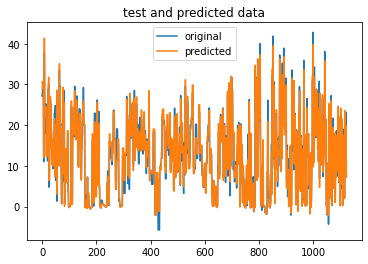

In [1448]:
import matplotlib.pyplot as plt 

x_ax = range(len(Y_test))
plt.plot(x_ax, Y_test, label="original")
plt.plot(x_ax, Y_pred, label="predicted")
plt.title("test and predicted data")
plt.legend()
plt.show()

In [1449]:
testdf['Predicted_fantasy'] = Y_pred
testdf['fantasy_points_ppr'] = Y_test

In [1450]:
player_df = pd.read_csv('2022_top_300_espn_ppr_projections.csv')
player_df.head()

,rank,first_name,last_name,team,position
0,1,jonathan,taylor,IND,RB
1,2,christian,mccaffrey,CAR,RB
2,3,cooper,kupp,LAR,WR
3,4,austin,ekeler,LAC,RB
4,5,justin,jefferson,MIN,WR


In [1451]:
qb_player_df = player_df.merge(testdf[['first_name','last_name','team','position','fantasy_points_ppr','Predicted_fantasy']], on=['first_name','last_name','team','position'])
qb_player_df.shape

(271, 7)

In [1452]:
qb_player_df['median'] = qb_player_df.groupby(['first_name','last_name'])['Predicted_fantasy'].transform('median')
qb_player_df = qb_player_df.drop_duplicates(['first_name','last_name'])

qb_player_df = qb_player_df.loc[qb_player_df['median'].sort_values(ascending=False).index]
qb_player_df['position_rank'] = qb_player_df['median'].rank(ascending=False) 
qb_player_df.drop(['rank','fantasy_points_ppr','Predicted_fantasy'], axis=1, inplace=True)
qb_player_df.reset_index(drop=True, inplace=True)
qb_player_df.head()

,first_name,last_name,team,position,median,position_rank
0,joshua,allen,BUF,QB,25.287130,1.0
1,tom,brady,TB,QB,24.054415,2.0
2,patrick,mahomes,KC,QB,23.072563,3.0
3,justin,herbert,LAC,QB,19.722849,4.0
4,aaron,rodgers,GB,QB,19.447746,5.0


In [1453]:

qb_player_df.to_csv('qb_ranked.csv')

### WR model

In [1454]:
weekly_wr_df.head()

,player_id,player_name,recent_team,season,week,season_type,completions,attempts,passing_yards,passing_tds,...,game_type,status_description_abbr,football_name,esb_id,gsis_it_id,smart_id,entry_year,rookie_year,draft_club,draft_number
0,00-0022921,L.Fitzgerald,ARI,2016,1,REG,0,0,0.0,0,...,REG,A01,Larry,FIT437493,28955,32004649-5443-7493-c0df-1747b7d5c143,2004.0,2004.0,ARI,3.0
1,00-0022921,L.Fitzgerald,ARI,2016,1,REG,0,0,0.0,0,...,REG,A01,Larry,FIT437493,28955,32004649-5443-7493-c0df-1747b7d5c143,2004.0,2004.0,ARI,3.0
2,00-0022921,L.Fitzgerald,ARI,2016,1,REG,0,0,0.0,0,...,REG,A01,Larry,FIT437493,28955,32004649-5443-7493-c0df-1747b7d5c143,2004.0,2004.0,ARI,3.0
3,00-0022921,L.Fitzgerald,ARI,2016,1,REG,0,0,0.0,0,...,REG,A01,Larry,FIT437493,28955,32004649-5443-7493-c0df-1747b7d5c143,2004.0,2004.0,ARI,3.0
4,00-0022921,L.Fitzgerald,ARI,2017,1,REG,0,0,0.0,0,...,REG,A01,Larry,FIT437493,28955,32004649-5443-7493-c0df-1747b7d5c143,2004.0,2004.0,ARI,3.0


In [1455]:
print(list(weekly_wr_df.columns))

['player_id', 'player_name', 'recent_team', 'season', 'week', 'season_type', 'completions', 'attempts', 'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_yards', 'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards', 'passing_yards_after_catch', 'passing_first_downs', 'passing_epa', 'passing_2pt_conversions', 'dakota', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions', 'receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards', 'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa', 'receiving_2pt_conversions', 'special_teams_tds', 'fantasy_points', 'fantasy_points_ppr', 'pacr', 'racr', 'target_share', 'air_yards_share', 'wopr', 'team', 'position', 'depth_chart_position', 'jersey_number', 'status', 'first_name', 'last_name', 'birth_date', 'height', 'weight', 'college', 'espn_id', 'spo

In [1456]:
weekly_wr_df['complete_attempts_pct'] = weekly_wr_df['completions']/weekly_wr_df['attempts']

In [1457]:
# try to keep as much as possible
wr_act_stats = weekly_wr_df[['player_id','first_name','last_name','team','position','season','week', 'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_yards', 'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards', 'passing_yards_after_catch', 'passing_first_downs', 'passing_epa', 'passing_2pt_conversions', 'dakota', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions', 'receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards', 'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa', 'receiving_2pt_conversions', 'special_teams_tds', 'fantasy_points', 'fantasy_points_ppr', 'pacr', 'racr', 'target_share', 'air_yards_share', 'wopr', 'team', 'position', 'years_exp', 'entry_year', 'rookie_year',  'draft_number', 'complete_attempts_pct']].copy().reset_index(drop=True)

In [1458]:
wr_act_stats = wr_act_stats.fillna(0)

In [1459]:
wr_act_stats = wr_act_stats.loc[:,~wr_act_stats.columns.duplicated()]
wr_act_stats = wr_act_stats.replace([np.inf, -np.inf], np.nan)

In [1460]:
# remove correlated
wr_act_stats = _corr(wr_act_stats, threshold=0.85, impute=0, keep=['fantasy_points_ppr'])
print(wr_act_stats.shape)

3. Keep:  passing_first_downs 0.13356978626782867  Remove:  passing_yards 0.13463480079354734
3. Keep:  sack_fumbles_lost 0.060067984102072404  Remove:  sack_fumbles 0.060067984102072404
3. Keep:  complete_attempts_pct 0.13172709259147702  Remove:  passing_first_downs 0.13356978626782867
3. Keep:  targets 0.175743173333122  Remove:  receptions 0.18596682340706053
3. Keep:  receiving_first_downs 0.18541925372365625  Remove:  receiving_yards 0.192917565005925
1. Keep:  fantasy_points_ppr  Remove:  receiving_first_downs
1. Keep:  fantasy_points_ppr  Remove:  fantasy_points
3. Keep:  air_yards_share 0.11509367797592245  Remove:  target_share 0.12338216402536116
3. Keep:  air_yards_share 0.11509367797592245  Remove:  wopr 0.12206969574798548
3. Keep:  rookie_year 0.04790972680226377  Remove:  entry_year 0.04790972680226377
Dropping below:  ['target_share', 'sack_fumbles', 'wopr', 'fantasy_points', 'receiving_first_downs', 'passing_first_downs', 'receiving_yards', 'entry_year', 'receptions',

In [1461]:
# permute the features for Wrapper feature selection
print(wr_act_stats.shape)
df = permute(wr_act_stats)
print(df.shape)

(43063, 42)
(43063, 76)


In [1462]:
# separate features to binary and continuous features
ids = [col for col in df.columns.tolist() if col not in ['player_id','first_name','last_name','team','position','season','week','fantasy_points_ppr']]
features = df.loc[:, ids]
bin_cols = [
    col for col in features if features[col].value_counts().index.isin([0, 1]).all()
]
cont_cols = [col for col in features.columns.tolist() if col not in bin_cols]
print(len(bin_cols))
print(len(cont_cols))

18
50


In [1463]:
## create tes-train split
X = df[bin_cols+cont_cols]
y = df["fantasy_points_ppr"]
## print df shape
print(X.shape)
print(y.shape)

(43063, 68)
(43063,)


In [1464]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import datetime
from sklearn.model_selection import GridSearchCV

xgb1 = XGBRegressor()
parameters = {
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [2, 3, 4],
              'min_child_weight': [4],
              'eta' : [0.1],
              'subsample': [0.7],
              'colsample_bytree': [0.8],
              'n_estimators': [200, 500, 1000]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 5,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X, y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[01:37:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
0.9606554207590362
{'colsample_bytree': 0.8, 'eta': 0.1, 'learning_rate': 0.03, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 1000, 'objective': 'reg:linear', 'subsample': 0.7}


In [1465]:
model.fit(X, y)
dset = pd.DataFrame({'attr':X.columns.tolist(),'importance':model.feature_importances_}).sort_values(by='importance', ascending=False).reset_index(drop=True)
attr = dset['attr'].tolist()
print(attr)

[01:37:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


['receiving_tds', 'targets', 'receiving_epa', 'rushing_tds', 'receiving_yards_after_catch', 'special_teams_tds', 'passing_tds', 'rushing_yards', 'rushing_first_downs', 'receiving_2pt_conversions', 'receiving_air_yards', 'rushing_epa', 'racr', 'passing_epa', 'receiving_fumbles_lost', 'receiving_fumbles', 'air_yards_share', 'carries', 'interceptions', 'rushing_fumbles_lost', 'rookie_year', 'draft_number', 'passing_2pt_conversions', 'passing_yards_after_catch', 'random_rookie_year', 'random_rushing_epa', 'random_rushing_yards', 'random_air_yards_share', 'random_receiving_epa', 'ran

In [1466]:
permutated = [name for name in attr if "random_" in name]
if len(permutated) == 0:
    top_n = len(attr)
else:
    print(permutated[0])
    top_n = attr.index(permutated[0])-1
top_n

random_rookie_year


23

In [1467]:
## create tes-train split
X = df[attr[:top_n]]
y = df["fantasy_points_ppr"]
## print df shape
print(X.shape)
print(y.shape)

(43063, 23)
(43063,)


In [1468]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import datetime
from sklearn.model_selection import GridSearchCV

xgb1 = XGBRegressor()
parameters = {
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [2, 3, 4],
              'min_child_weight': [4],
              'eta' : [0.1],
              'subsample': [0.7],
              'colsample_bytree': [0.8],
              'n_estimators': [200, 500, 1000]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 5,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X, y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[01:43:36] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
0.9607492852841153
{'colsample_bytree': 0.8, 'eta': 0.1, 'learning_rate': 0.03, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 1000, 'objective': 'reg:linear', 'subsample': 0.7}


In [1469]:
xgb_params = {}
for key, val in xgb_grid.best_params_.items():
        xgb_params[key] = val

In [1470]:
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold, KFold
from xgboost import XGBRegressor

# create an xgboost regression model
model = XGBRegressor(params=xgb_params)


# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

# kfold = KFold(n_splits=10, shuffle=True)
# kf_cv_scores = cross_val_score(model, X, y, cv=kfold )
# print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

Mean MAE: 0.802 (0.012)


In [1471]:
model.fit(X, y)
dset = pd.DataFrame({'attr':X.columns.tolist(),'importance':model.feature_importances_}).sort_values(by='importance', ascending=False).reset_index(drop=True)
attr = dset['attr'].tolist()
print(attr)

[01:44:28] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


['receiving_tds', 'targets', 'receiving_epa', 'rushing_tds', 'receiving_yards_after_catch', 'special_teams_tds', 'passing_tds', 'rushing_yards', 'receiving_2pt_conversions', 'rushing_first_downs', 'carries', 'receiving_air_yards', 'rushing_epa', 'racr', 'passing_epa', 'receiving_fumbles', 'receiving_fumbles_lost', 'rushing_fumbles_lost', 'interceptions', 'rookie_year', 'draft_number', 'air_yards_share', 'passing_2pt_conversions']


In [1472]:
# Model validation
# Use previous seasons data to predict 2021 season
cols = ['player_id','first_name','last_name','team','position','season','week','fantasy_points_ppr'] + attr


traindf = wr_act_stats[cols][(wr_act_stats['season']<=2020)].fillna(0).copy().drop_duplicates().reset_index(drop=True)
print(traindf.shape)
#Create Test Dataset
testdf  = wr_act_stats[cols][wr_act_stats['season']>=2021].fillna(0).copy().drop_duplicates().reset_index(drop=True)
print(testdf.shape)

(17770, 31)
(3437, 31)


In [1473]:
#Columns We Can't Include In Our Features Datasets
dcols = ['player_id','first_name','last_name','team','position','season','week','fantasy_points_ppr']
#X = Features, Y = Target
#train = training dataset, test = testing dataset
X_train, Y_train = traindf.drop(dcols, axis = 1), traindf['fantasy_points_ppr']
X_test, Y_test = testdf.drop(dcols, axis = 1), testdf['fantasy_points_ppr']
#Use For Analysis After Model & Predictions Created
pred_df = testdf.copy()

In [1474]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
mae = mean_absolute_error(Y_test, Y_pred)
print("MAE: %.2f" % mse)
mape = mean_absolute_percentage_error(Y_test, Y_pred)
print("MAPE: %.2f" % mape)

[01:44:30] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


MAE: 4.66
MAPE: 160237294190592.00


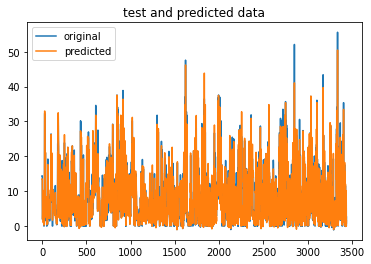

In [1475]:
import matplotlib.pyplot as plt 

x_ax = range(len(Y_test))
plt.plot(x_ax, Y_test, label="original")
plt.plot(x_ax, Y_pred, label="predicted")
plt.title("test and predicted data")
plt.legend()
plt.show()

In [1476]:
testdf['Predicted_fantasy'] = Y_pred
testdf['fantasy_points_ppr'] = Y_test

In [1477]:
player_df = pd.read_csv('2022_top_300_espn_ppr_projections.csv')
player_df.head()

,rank,first_name,last_name,team,position
0,1,jonathan,taylor,IND,RB
1,2,christian,mccaffrey,CAR,RB
2,3,cooper,kupp,LAR,WR
3,4,austin,ekeler,LAC,RB
4,5,justin,jefferson,MIN,WR


In [1478]:
wr_player_df = player_df.merge(testdf[['first_name','last_name','team','position','fantasy_points_ppr','Predicted_fantasy']], on=['first_name','last_name','team','position'])
wr_player_df.shape

(560, 7)

In [1479]:
wr_player_df['median'] = wr_player_df.groupby(['first_name','last_name'])['Predicted_fantasy'].transform('median')
wr_player_df = wr_player_df.drop_duplicates(['first_name','last_name'])

wr_player_df = wr_player_df.loc[wr_player_df['median'].sort_values(ascending=False).index]
wr_player_df['position_rank'] = wr_player_df['median'].rank(ascending=False) 
wr_player_df.drop(['rank','fantasy_points_ppr','Predicted_fantasy'], axis=1, inplace=True)
wr_player_df.reset_index(drop=True, inplace=True)
wr_player_df.head()

,first_name,last_name,team,position,median,position_rank
0,justin,jefferson,MIN,WR,19.829103,1.0
1,mike,evans,TB,WR,18.626549,2.0
2,diontae,johnson,PIT,WR,17.788610,3.0
3,adam,thielen,MIN,WR,15.872649,4.0
4,brandin,cooks,HOU,WR,15.185743,5.0


In [1480]:

wr_player_df.to_csv('wr_ranked.csv')

### TE model

In [1481]:
weekly_te_df.head()

,player_id,player_name,recent_team,season,week,season_type,completions,attempts,passing_yards,passing_tds,...,game_type,status_description_abbr,football_name,esb_id,gsis_it_id,smart_id,entry_year,rookie_year,draft_club,draft_number
0,00-0021547,A.Gates,LAC,2016,1,REG,0,0,0.0,0,...,REG,A01,Antonio,GAT194627,28495,32004741-5419-4627-d7b9-c6962c8e21f2,2003.0,2003.0,None,NaN
1,00-0021547,A.Gates,LAC,2016,1,REG,0,0,0.0,0,...,REG,A01,Antonio,GAT194627,28495,32004741-5419-4627-d7b9-c6962c8e21f2,2003.0,2003.0,None,NaN
2,00-0021547,A.Gates,LAC,2016,1,REG,0,0,0.0,0,...,DIV,A01,Antonio,GAT194627,28495,32004741-5419-4627-d7b9-c6962c8e21f2,2003.0,2003.0,None,NaN
3,00-0021547,A.Gates,LAC,2017,1,REG,0,0,0.0,0,...,REG,A01,Antonio,GAT194627,28495,32004741-5419-4627-d7b9-c6962c8e21f2,2003.0,2003.0,None,NaN
4,00-0021547,A.Gates,LAC,2017,1,REG,0,0,0.0,0,...,REG,A01,Antonio,GAT194627,28495,32004741-5419-4627-d7b9-c6962c8e21f2,2003.0,2003.0,None,NaN


In [1482]:
print(list(weekly_te_df.columns))

['player_id', 'player_name', 'recent_team', 'season', 'week', 'season_type', 'completions', 'attempts', 'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_yards', 'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards', 'passing_yards_after_catch', 'passing_first_downs', 'passing_epa', 'passing_2pt_conversions', 'dakota', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions', 'receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards', 'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa', 'receiving_2pt_conversions', 'special_teams_tds', 'fantasy_points', 'fantasy_points_ppr', 'pacr', 'racr', 'target_share', 'air_yards_share', 'wopr', 'team', 'position', 'depth_chart_position', 'jersey_number', 'status', 'first_name', 'last_name', 'birth_date', 'height', 'weight', 'college', 'espn_id', 'spo

In [1483]:
weekly_te_df['complete_attempts_pct'] = weekly_te_df['completions']/weekly_te_df['attempts']

In [1484]:
# try to keep as much as possible
te_act_stats = weekly_te_df[['player_id','first_name','last_name','team','position','season','week', 'complete_attempts_pct', 'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_yards', 'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards', 'passing_yards_after_catch', 'passing_first_downs', 'passing_epa', 'passing_2pt_conversions', 'dakota', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions', 'receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards', 'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa', 'receiving_2pt_conversions', 'special_teams_tds', 'fantasy_points', 'fantasy_points_ppr', 'pacr', 'racr', 'target_share', 'air_yards_share', 'wopr', 'years_exp', 'entry_year', 'rookie_year', 'draft_number']].copy().reset_index(drop=True)

In [1485]:
te_act_stats = te_act_stats.fillna(0)

In [1486]:
te_act_stats = te_act_stats.loc[:,~te_act_stats.columns.duplicated()]
te_act_stats = te_act_stats.replace([np.inf, -np.inf], np.nan)

In [1487]:
# remove correlated
te_act_stats = _corr(te_act_stats, threshold=0.85, impute=0, keep=['fantasy_points_ppr'])
print(te_act_stats.shape)

3. Keep:  passing_first_downs 0.14159621247610604  Remove:  complete_attempts_pct 0.14159621247610604
3. Keep:  rushing_fumbles_lost 0.06455486356240599  Remove:  rushing_fumbles 0.06455486356240599
3. Keep:  targets 0.20345511089252313  Remove:  receptions 0.2144010981267109
3. Keep:  receiving_first_downs 0.21309918164364924  Remove:  receiving_yards 0.22234548581163388
1. Keep:  fantasy_points_ppr  Remove:  receiving_first_downs
1. Keep:  fantasy_points_ppr  Remove:  fantasy_points
3. Keep:  air_yards_share 0.1436824373239636  Remove:  target_share 0.14886267493096123
3. Keep:  air_yards_share 0.1436824373239636  Remove:  wopr 0.15100590203517186
3. Keep:  entry_year 0.11246831673687599  Remove:  rookie_year 0.11250163174486098
Dropping below:  ['target_share', 'wopr', 'complete_attempts_pct', 'fantasy_points', 'rookie_year', 'receiving_first_downs', 'rushing_fumbles', 'receiving_yards', 'receptions']
(22005, 43)


In [1488]:
# permute the features for Wrapper feature selection
print(te_act_stats.shape)
df = permute(te_act_stats)
print(df.shape)

(22005, 43)
(22005, 78)


In [1489]:
# separate features to binary and continuous features
ids = [col for col in df.columns.tolist() if col not in ['player_id','first_name','last_name','team','position','season','week','fantasy_points_ppr']]
features = df.loc[:, ids]
bin_cols = [
    col for col in features if features[col].value_counts().index.isin([0, 1]).all()
]
cont_cols = [col for col in features.columns.tolist() if col not in bin_cols]
print(len(bin_cols))
print(len(cont_cols))

28
42


In [1490]:
## create tes-train split
X = df[bin_cols+cont_cols]
y = df["fantasy_points_ppr"]
## print df shape
print(X.shape)
print(y.shape)

(22005, 70)
(22005,)


In [1491]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import datetime
from sklearn.model_selection import GridSearchCV

xgb1 = XGBRegressor()
parameters = {
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [2, 3, 4],
              'min_child_weight': [4],
              'eta' : [0.1],
              'subsample': [0.7],
              'colsample_bytree': [0.8],
              'n_estimators': [200, 500, 1000]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 5,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X, y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[01:51:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
0.9650034424990231
{'colsample_bytree': 0.8, 'eta': 0.1, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 1000, 'objective': 'reg:linear', 'subsample': 0.7}


In [1492]:
model.fit(X, y)
dset = pd.DataFrame({'attr':X.columns.tolist(),'importance':model.feature_importances_}).sort_values(by='importance', ascending=False).reset_index(drop=True)
attr = dset['attr'].tolist()
print(attr)

[01:51:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


['receiving_tds', 'targets', 'receiving_epa', 'receiving_yards_after_catch', 'rushing_tds', 'receiving_2pt_conversions', 'rushing_fumbles_lost', 'receiving_fumbles_lost', 'special_teams_tds', 'passing_tds', 'receiving_air_yards', 'rushing_epa', 'racr', 'passing_first_downs', 'air_yards_share', 'rushing_yards', 'draft_number', 'entry_year', 'receiving_fumbles', 'passing_2pt_conversions', 'passing_yards_after_catch', 'passing_air_yards', 'carries', 'random_draft_number', 'random_air_yards_share', 'random_receiving_epa', 'random_rushing_tds', 'random_receiving_fumbles_lost', 'rando

In [1493]:
permutated = [name for name in attr if "random_" in name]
if len(permutated) == 0:
    top_n = len(attr)
else:
    print(permutated[0])
    top_n = attr.index(permutated[0])-1
top_n

random_draft_number


22

In [1494]:
## create tes-train split
X = df[attr[:top_n]]
y = df["fantasy_points_ppr"]
## print df shape
print(X.shape)
print(y.shape)

(22005, 22)
(22005,)


In [1495]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import datetime
from sklearn.model_selection import GridSearchCV

xgb1 = XGBRegressor()
parameters = {
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [2, 3, 4],
              'min_child_weight': [4],
              'eta' : [0.1],
              'subsample': [0.7],
              'colsample_bytree': [0.8],
              'n_estimators': [200, 500, 1000]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 5,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X, y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[01:54:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
0.9650460926817745
{'colsample_bytree': 0.8, 'eta': 0.1, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 1000, 'objective': 'reg:linear', 'subsample': 0.7}


In [1496]:
xgb_params = {}
for key, val in xgb_grid.best_params_.items():
        xgb_params[key] = val

In [1497]:
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold, KFold
from xgboost import XGBRegressor

# create an xgboost regression model
model = XGBRegressor(params=xgb_params)


# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

# kfold = KFold(n_splits=10, shuffle=True)
# kf_cv_scores = cross_val_score(model, X, y, cv=kfold )
# print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

Mean MAE: 0.424 (0.013)


In [1498]:
model.fit(X, y)
dset = pd.DataFrame({'attr':X.columns.tolist(),'importance':model.feature_importances_}).sort_values(by='importance', ascending=False).reset_index(drop=True)
attr = dset['attr'].tolist()
print(attr)

[01:55:29] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


['receiving_tds', 'targets', 'receiving_epa', 'receiving_yards_after_catch', 'rushing_tds', 'receiving_2pt_conversions', 'rushing_fumbles_lost', 'special_teams_tds', 'passing_tds', 'receiving_air_yards', 'rushing_epa', 'receiving_fumbles_lost', 'passing_first_downs', 'racr', 'air_yards_share', 'draft_number', 'rushing_yards', 'entry_year', 'receiving_fumbles', 'passing_2pt_conversions', 'passing_air_yards', 'passing_yards_after_catch']


In [1499]:
# Model validation
# Use previous seasons data to predict 2021 season
cols = ['player_id','first_name','last_name','team','position','season','week','fantasy_points_ppr'] + attr


traindf = te_act_stats[cols][(te_act_stats['season']<=2020)].fillna(0).copy().drop_duplicates().reset_index(drop=True)
print(traindf.shape)
#Create Test Dataset
testdf  = te_act_stats[cols][te_act_stats['season']>=2021].fillna(0).copy().drop_duplicates().reset_index(drop=True)
print(testdf.shape)

(9274, 30)
(1632, 30)


In [1500]:
#Columns We Can't Include In Our Features Datasets
dcols = ['player_id','first_name','last_name','team','position','season','week','fantasy_points_ppr']
#X = Features, Y = Target
#train = training dataset, test = testing dataset
X_train, Y_train = traindf.drop(dcols, axis = 1), traindf['fantasy_points_ppr']
X_test, Y_test = testdf.drop(dcols, axis = 1), testdf['fantasy_points_ppr']
#Use For Analysis After Model & Predictions Created
pred_df = testdf.copy()

In [1501]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
mae = mean_absolute_error(Y_test, Y_pred)
print("MAE: %.2f" % mse)
mape = mean_absolute_percentage_error(Y_test, Y_pred)
print("MAPE: %.2f" % mape)

[01:55:30] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


MAE: 4.66
MAPE: 116590083309568.00


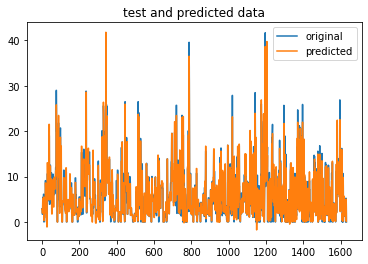

In [1502]:
import matplotlib.pyplot as plt 

x_ax = range(len(Y_test))
plt.plot(x_ax, Y_test, label="original")
plt.plot(x_ax, Y_pred, label="predicted")
plt.title("test and predicted data")
plt.legend()
plt.show()

In [1503]:
testdf['Predicted_fantasy'] = Y_pred
testdf['fantasy_points_ppr'] = Y_test

In [1504]:
player_df = pd.read_csv('2022_top_300_espn_ppr_projections.csv')
player_df.head()

,rank,first_name,last_name,team,position
0,1,jonathan,taylor,IND,RB
1,2,christian,mccaffrey,CAR,RB
2,3,cooper,kupp,LAR,WR
3,4,austin,ekeler,LAC,RB
4,5,justin,jefferson,MIN,WR


In [1505]:
te_player_df = player_df.merge(testdf[['first_name','last_name','team','position','fantasy_points_ppr','Predicted_fantasy']], on=['first_name','last_name','team','position'])
te_player_df.shape

(280, 7)

In [1506]:
te_player_df['median'] = te_player_df.groupby(['first_name','last_name'])['Predicted_fantasy'].transform('median')
te_player_df = te_player_df.drop_duplicates(['first_name','last_name'])

te_player_df = te_player_df.loc[te_player_df['median'].sort_values(ascending=False).index]
te_player_df['position_rank'] = te_player_df['median'].rank(ascending=False) 
te_player_df.drop(['rank','fantasy_points_ppr','Predicted_fantasy'], axis=1, inplace=True)
te_player_df.reset_index(drop=True, inplace=True)
te_player_df.head()

,first_name,last_name,team,position,median,position_rank
0,travis,kelce,KC,TE,16.406006,1.0
1,mark,andrews,BAL,TE,14.707260,2.0
2,dalton,schultz,DAL,TE,12.842571,3.0
3,darren,waller,LV,TE,12.020907,4.0
4,dallas,goedert,PHI,TE,11.171933,5.0


In [1507]:
te_player_df.to_csv('te_ranked.csv')

### Add overall_rank

In [1509]:
final_df = rb_player_df.append(qb_player_df).append(wr_player_df).append(te_player_df)
final_df['overall_rank'] = final_df['median'].rank(ascending=False) 
final_df.drop(['median'], axis=1, inplace=True)
te_player_df.reset_index(drop=True, inplace=True)
final_df.to_csv('nfl_ranked.csv')

### END